
# Batch Density-Diversity-Distribution-Distance Sampling


In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation
from sklearn.datasets import make_blobs

from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary, \
    plot_contour_for_samples

from skactiveml.classifier import MixtureModelClassifier
from skactiveml.pool import FourDs, CoreSet, TypiClust, Badge
from sklearn.mixture import GaussianMixture

MovieWriter ffmpeg unavailable; using Pillow instead.


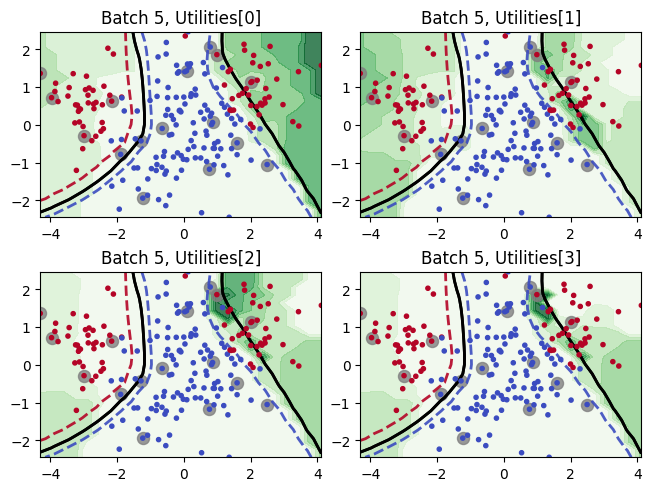

In [4]:
random_state = np.random.RandomState(1)

# Build a dataset.
X, y_true = make_blobs(n_samples=200, n_features=2,
                       centers=[[0, 1], [-3, .5], [-1, -1], [2, 1], [1, -.5]],
                       cluster_std=.7, random_state=random_state)
y_true = y_true % 2
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

# Initialise the classifier.
clf = MixtureModelClassifier(classes=[0, 1], mixture_model=GaussianMixture(n_components=5))
# Initialise the query strategy.
qs = Badge()

# Preparation for plotting.
fig, axs = plt.subplots(2, 2, constrained_layout=True)
feature_bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
artists = [[] for j in range(5)]

# The active learning cycle:
n_cycles = 5
for c in range(n_cycles):
    # Fit the classifier.
    clf.fit(X, y)

    # Get labeled instances.
    X_labeled = X[labeled_indices(y)]

    # Query the next instance/s.
    # query_idx, utilities = qs.query(X=X, y=y, batch_size=4, return_utilities=True)
    query_idx, utilities = qs.query(X=X, y=y, clf=clf, batch_size=4, return_utilities=True)

    # Plot the labeled data.
    for i, ax in enumerate(axs.flatten()):
        coll_old = list(ax.collections)
        plot_contour_for_samples(X, utilities[i], res=25,
                                 feature_bound=feature_bound, replace_nan=None, ax=ax)
        ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap="coolwarm", marker=".",
                   zorder=2)
        ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c="grey", alpha=.8,
                   marker=".", s=300)
        ax = plot_decision_boundary(clf, feature_bound, ax=ax)
        ax.set_title(f"Batch {c+1}, Utilities[{i}]")

        for x in ax.collections:
            if x not in coll_old:
                artists[c].append(x)

    # Label the queried instances.
    y[query_idx] = y_true[query_idx]

ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True)
f = r"/Users/chengjiaying/scikit-activeml/tutorials/Badge_bs_4.pdf" 
ani.save(f)